In [280]:
# Core imports 
from copy import deepcopy
import importlib
import warnings

# Installed imports 
import matplotlib.pyplot as plt
import numpy as np

# Local imports
import Driving
from Driving import NavigationDemoLogParser, FrameParsers, driveUtilities
from Driving.NavigationDemoLogParser import NavigationDemoLogParser
import src.learning.training_utils
import src.utils.data_loading
import src.utils.data_processing
import src.utils.experiment_utils
import src.utils.visualization

from src.utils.io import load_hdf5_array, save_hdf5_dataset

importlib.reload(src.utils.data_loading)
importlib.reload(src.utils.data_processing)
importlib.reload(src.learning.training_utils)
importlib.reload(src.utils.experiment_utils)
importlib.reload(src.utils.visualization)

from src.learning.training_utils import *
from src.utils.data_loading import *
from src.utils.data_processing import *
from src.utils.experiment_utils import * 
from src.utils.visualization import *

Set parameters

In [281]:
seconds_per_TR = 2.0045 # generally to have around 
seconds_per_sample = 1/15

# Data parameters 
k_closest_vehicles = 7
k_closest_pedestrians = 0

# for subsampling trajectories
length_sub_trajectory = 75
dt_samples_sub_trajectory = 1 
subsample_sub_trajectories = 5 # how widely to space the trajectories you're pulling from the demonstrations  


params = Params(k_closest_vehicles, k_closest_pedestrians, length_sub_trajectory, dt_samples_sub_trajectory, subsample_sub_trajectories, seconds_per_sample)
params.road_width

1200

Start by loading the demonstrations

In [282]:
# Load the full demonstrations 
train_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/train_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
validation_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/validation_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
test_demonstrations = load_demonstrations_file(f"./Data/Demonstrations/test_demonstrations_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npz")
centerlines = load_centerlines("./Data/LogAndLabelData/map_centerlines.npz")

# Load IDS of the demonstrations to use for training, validation, and testing
train_ids = np.load(f"./Data/Demonstrations/train_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
validation_ids = np.load(f"./Data/Demonstrations/validation_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
test_ids = np.load(f"./Data/Demonstrations/test_ids_k_closest_vehicles={k_closest_vehicles}_k_closest_pedestrians={k_closest_pedestrians}.npy")
all_ids = np.concatenate((train_ids, validation_ids, test_ids))

In [283]:
 # Pull out just the states, make the centerline direction adjustments, then convert to line frame
 train_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in train_demonstrations]
 validation_demonstration_states_world_frame = [fix_centerline_direction(demonstration[0], k_closest_vehicles, k_closest_pedestrians) for demonstration in validation_demonstrations]

 train_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in train_demonstration_states_world_frame]
 validation_demonstration_states_line_frame = [line_frame(demonstration_states, k_closest_vehicles, k_closest_pedestrians) for demonstration_states in validation_demonstration_states_world_frame]

#### Helper function to get out a y-only state from the full state. This also flips things so that the ego vehicle is always facing upwards. 

In [284]:
def get_1d_state(state, params):
    """ 
        Given a state, return y, v_y, closest_vehicle_y, closest_vehicle_v_y
        flipped so that the ego vehicle is facing up.

        Returns the state plus a boolean telling you whether it was flipped
    """
    # Pull out the ego vehicle state
    x, y, angle, speed = state[0:4]
    v_y = speed * np.sin(angle)

    # Consider the vehicle as facing up or down depending on the angle 
    upwards = True if np.sin(angle) > 0 else False

    # Find the closest vehicle y position in the appropriate direction 
    # relative to the ego vehicle
    closest_vehicle_y = np.inf if upwards else -np.inf
    closest_vehicle_v_y = np.inf if upwards else -np.inf

    centerline_index = centerline_col(params.k_closest_vehicles, params.k_closest_pedestrians)
    centerline_x = state[centerline_index]
    
    for vehicle_index in range(params.k_closest_vehicles):
        vehicle_col = vehicle_index_to_col(vehicle_index)
        vehicle_x, vehicle_y, vehicle_angle, vehicle_speed = state[vehicle_col:vehicle_col+4]
        vehicle_v_y = vehicle_speed * np.sin(vehicle_angle)

        # Check that it's on the same side of the centerline as us 
        if np.sign(vehicle_x - centerline_x) == np.sign(x - centerline_x):
            # make sure the car is in the lane and not on a road to our right
            if np.abs(vehicle_x - centerline_x) <= params.road_width/2:
                if upwards and  vehicle_y > y and vehicle_y < closest_vehicle_y:
                    closest_vehicle_y = vehicle_y
                    closest_vehicle_v_y = vehicle_v_y
                elif not upwards and vehicle_y < y and vehicle_y > closest_vehicle_y:
                    closest_vehicle_y = vehicle_y
                    closest_vehicle_v_y = vehicle_v_y

    if not upwards:
        # Flip everything upside down to compute 
        y = -y
        v_y = -v_y
        closest_vehicle_y = -closest_vehicle_y
        closest_vehicle_v_y = -closest_vehicle_v_y

    return y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards


##### Define the IDM controller 

In [285]:
def ramp(x):
    return np.maximum(np.minimum(x, 1), -1)

def idm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params):
    """     
        Given a state, return the derivatives of y and v_y. Also return
        a vector of auxiliary features used in the computation.
    """
    # Compute the velocity and acceleration based on the 
    # distance to the closest vehicle. 
    # v_0, s_0, T, a, b, and l are all parameters of the IDM
    v_0, s_0, T, a, b, l, delta = model_params

    # Compute approaching rate and s_star 
    approaching_rate = v_y - closest_vehicle_v_y if closest_vehicle_v_y != np.inf else 0
    s_star = np.maximum(s_0 + v_y * T + np.abs(v_y) * approaching_rate / (2 * np.sqrt(a * b)), 0)
    # Compute the change in speed and acceleration
    s = closest_vehicle_y - y - l
    if s <= 1.0:
        #print("s less than 0")
        warnings.warn("s < 0, crashed")
        s = 1.0 #s_star/2 # what to do here instead?

    y_dot = v_y 
    if s == np.inf:
        v_y_dot = a * ramp(1 - np.sign(v_y)*(v_y/v_0)**delta)
    else:
        v_y_dot = a * ramp(1 - np.sign(v_y)*(v_y/v_0)**delta - (s_star/s)**2)
    # print("----------")
    # print("closest vehicle v_y: ", closest_vehicle_v_y)
    # print("s: ", s)
    # print("approaching rate: ", approaching_rate)
    # print("s star: ", s_star)
    # print("y_dot: ", y_dot)
    # print("v_y_dot: ", v_y_dot)

    auxiliary_features = np.array([v_y, approaching_rate, \
                                   v_y/v_0, (v_y/v_0)**delta, \
                                   v_y * T, np.abs(v_y) * approaching_rate / (2 * np.sqrt(a * b)), \
                                   s_star, s_star/s, (s_star/s)**2, v_y_dot])

    if np.isnan(v_y_dot):
        print("v_y_dot is nan")
        print("auxiliary features: ", auxiliary_features)
    
    # Check if v_y is nan 
    if np.isnan(v_y):
        print("v_y is nan")
        print("auxiliary features: ", auxiliary_features)


    return y_dot, v_y_dot, auxiliary_features


##### Define the OVM Controller

In [286]:
def ovm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params):
    # https://journals.aps.org/pre/pdf/10.1103/PhysRevE.58.5429
    # Get the desired speed function
    delta_y = closest_vehicle_y - y
    delta_y_m = delta_y / 100
    
    a_m_s_s, scale, d, e, shift = model_params
    v_optimal_m_s = scale * (np.tanh(d * (delta_y_m - e)) + shift) #16.8 * (np.tanh(0.0860 * (delta_y_m - 25)) + 0.913)
    # Ceiling on the desired speed
    #v_optimal_m_s = np.min([v_optimal_m_s, 12.6])

    v_y_m_s = v_y / 100
    
    # Calculate the derivatives 
    y_dot = v_y
    v_y_dot_m_s = a_m_s_s * (v_optimal_m_s - v_y_m_s)
    v_y_dot = v_y_dot_m_s * 100 # convert back to cm/s/s

    return y_dot, v_y_dot, np.array([v_y, delta_y, v_optimal_m_s, v_y_dot_m_s])

#### Define a update function that's applicable to anything that maps the 1-d state to a derivative in y, a derivative in v_y, and some auxiliary features used in the computation.

In [287]:
def update_1d_line_frame(state, dt, model_params, params, deriv_function):
    """ 
        https://en.wikipedia.org/wiki/Intelligent_driver_model
        Map from a current state to a next 
        ego vehicle state (x, y, angle, speed)
    """
    # Flip the state so that the ego vehicle is facing up
    y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards = get_1d_state(state, params)

    # Actually run the model now that we've put it into 
    # a standard frame
    y_dot, v_y_dot, _ = deriv_function(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params)

    # Compute the new state
    x = state[0]
    new_x = x
    new_y = y + y_dot * dt
    new_angle = np.pi/2
    new_v_y = v_y + v_y_dot * dt

    # If was downwards, flip things back
    if not upwards:
        new_y = -new_y
        new_v_y = -new_v_y
        new_angle = -np.pi/2

        new_speed = -new_v_y # since facing down, speed is in direction of heading, so will be flipped sign from it 

    return np.array([new_x, new_y, new_angle, new_speed])


#### Rollout and animate for a given demonstration.

In [288]:
original_states = deepcopy(train_demonstration_states_line_frame[0][70:, :])

# Setup the model params for idm and ovm
# v_0, centimeters per second, 35mph is 1565, 25mph is 1118
# s_0, centimeters, desired minimum distance between vehicles
# T, seconds, desired time headway 
# a, maximum vehicle acceleration, 60mph/2.3seconds = 1166 cm/s/s... maybe slow it down to 60mph/4 seconds? 671
# b, comfortable braking deceleration
# l, centimeters
# delta, exponent in the IDM equation, typically set to 4
idm_params = [1118, 500, 1.6, 671, 500, 470, 4] 

# v_optimal = scale * (tanh(d * (delta y - e)) + offset)
# a, meters per second squared 
# shift, d, e, offset
ovm_params = [2.0, 8, 0.0860, 25, 0.913]

# Setup the updates for each of your models
idm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, idm_params, params, idm_standard_derivatives)
ovm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, ovm_params, params, ovm_standard_derivatives)

rollout_states_idm = rollout_controller_line_frame(original_states, idm_update_fcn, params)
rollout_states_ovm = rollout_controller_line_frame(original_states, ovm_update_fcn, params)


## IDM Animation

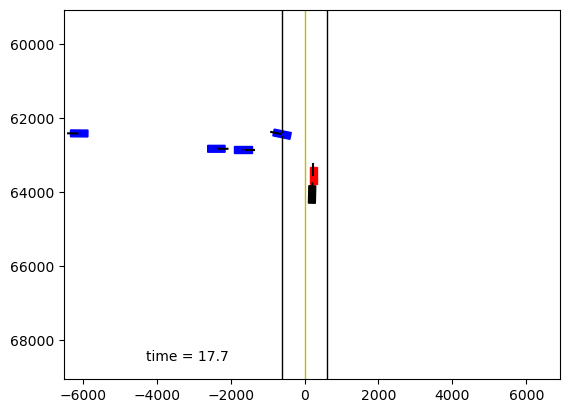

In [289]:
animate_trajectory(original_states, rollout_states_idm, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=0.3, render_speedup=8.0, subsample=7, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")

## OVM Animation

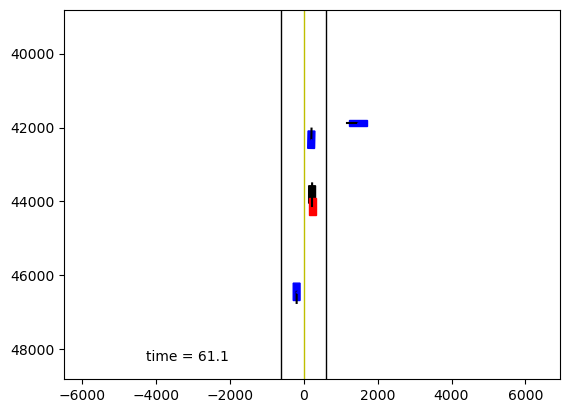

In [290]:
animate_trajectory(original_states, rollout_states_ovm, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=1.0, render_speedup=8.0, subsample=7, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")

# Fitting the parameters of IDM

#### ~~First, we get out a dataset of subtrajectories~~
#### We rollout with each model through each demonstration with randomly sampled parameters, then pick the best

In [291]:
# # Gather sub-trajectories for each demonstration, then stack them 
# # into a single matrix of num_sub_trajectories x length_sub_trajectory x num_states
# train_subs_per_demonstration = [get_sub_trajectories(demonstration_states, params) for demonstration_states in train_demonstration_states_line_frame]
# train_sub_trajectories = np.vstack(train_subs_per_demonstration)

# validation_subs_per_demonstration = [get_sub_trajectories(demonstration_states, params) for demonstration_states in validation_demonstration_states_line_frame]
# validation_sub_trajectories = np.vstack(validation_subs_per_demonstration)

In [292]:
# Rollout using idm for a sub-trajectory
# sample_to_rollout = 15
# rollout_sub = rollout_controller_line_frame(train_sub_trajectories[sample_to_rollout, :, :], idm_update_fcn, params)

# # animate the rolled out sub trajectory
# animate_trajectory(train_sub_trajectories[sample_to_rollout, :, :], rollout_sub, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=1.0, render_speedup=8.0, subsample=7, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")

In [293]:
# class Deriv1DModel(nn.Module):
#     def __init__(self, deriv_fcn, initial_model_params, params):
#         super().__init__()
        
#         self.deriv_fcn = deriv_fcn
#         self.model_params = nn.Parameter(torch.tensor(initial_model_params, dtype=torch.float32))
#         self.params = params

#     def forward(self, trajectory):
#         idm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, self.model_params, params, self.deriv_fcn)
#         return rollout_controller_line_frame(trajectory, idm_update_fcn, params)

# Test out that your model works
# model = Deriv1DModel(idm_standard_derivatives, idm_params, params)
# rollout = model(torch.tensor(train_sub_trajectories[sample_to_rollout, :, :], dtype=torch.float32))
# rollout - rollout_sub

In [294]:
# bad_state = rollout[int(4.2*15)-1, :]
# new_ego = update_1d_line_frame(bad_state, 1/15, idm_params, params, idm_standard_derivatives)
# print("old ego: ", bad_state[0:4])
# print("new ego: ", new_ego)

In [295]:
# idm_params = [667.99723438, 474.86535436,   2.9982526,  350.19576365, 801.86565115,
#  674.35213338,   4.]
# truncated_run = train_demonstration_states_line_frame[0][0:, :]
# idm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, idm_params, params, idm_standard_derivatives)

# rollout = rollout_controller_line_frame(truncated_run, idm_update_fcn, params)
# # animate rollout
# animate_trajectory(truncated_run, rollout, None, [0], params.k_closest_vehicles, params.k_closest_pedestrians, percent_to_animate=0.2, render_speedup=8.0, subsample=1, export_as_gif=False, export_as_mp4=False, filename="./Output/animation")

In [296]:
def eval_deriv_model(demonstration_states, deriv_fcn, model_params, params):
    idm_update_fcn = lambda state, dt, params: update_1d_line_frame(state, dt, model_params, params, deriv_fcn)

    total_loss = 0.0
    for demonstration in demonstration_states:
        rollout = rollout_controller_line_frame(demonstration, idm_update_fcn, params)
        total_loss += np.sum(np.square(rollout[:, 1] - demonstration[:, 1]))

    return total_loss

def uniform_sample_optimization(loss_fcn, lower_bounds, upper_bounds, n_samples):
    n = len(lower_bounds)
    best_loss = np.inf
    best_sample = None
    for i in tqdm(range(n_samples)):
        sample = np.random.uniform(lower_bounds, upper_bounds)

        loss = loss_fcn(sample)
        if loss < best_loss:
            best_loss = loss
            best_sample = sample
            print("cur log loss: ", np.log(loss))
            print("cur best sample: ", best_sample)
    
    return best_sample, best_loss


#### Fit the parameters for IDM

In [297]:
# find loss on our hand-tuned params
idm_params_hand_tuned = [1118, 500, 1.6, 671, 500, 470, 4]
loss = eval_deriv_model(train_demonstration_states_line_frame, idm_standard_derivatives, idm_params_hand_tuned, params)
print("log loss hand tuned: ", np.log(loss))

/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_20925/2489535679.py:21: UserWarning: s < 0, crashed
  warnings.warn("s < 0, crashed")


log loss hand tuned:  27.16986090032713


In [298]:
runs = train_demonstration_states_line_frame # train_demonstration_states_line_frame[0][0:, :]
lower_bounds_idm = [500, 250, 0.8, 100, 250, 470, 4]
upper_bounds_idm = [2000, 1000, 3.2, 1200, 1000, 470, 4]
best_idm_params, best_loss = uniform_sample_optimization(lambda x: eval_deriv_model(runs, idm_standard_derivatives, x, params), lower_bounds, upper_bounds, 100)

print("best idm params: ", best_idm_params)
print("best log loss: ", np.log(best_loss))

  0%|          | 0/100 [00:00<?, ?it/s]/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_20925/2489535679.py:21: UserWarning: s < 0, crashed
  warnings.warn("s < 0, crashed")
  1%|          | 1/100 [00:00<01:20,  1.23it/s]

cur log loss:  25.70343477651856
cur best sample:  [538.89391243 435.64188516   1.2816755  706.24360124 627.41449081
 713.67101306   4.        ]


  4%|▍         | 4/100 [00:02<01:04,  1.49it/s]

cur log loss:  25.515018198873264
cur best sample:  [ 740.11262124  702.37769741    1.58238056 1154.03556931  405.19350042
  402.04424083    4.        ]


  6%|▌         | 6/100 [00:03<00:59,  1.59it/s]

cur log loss:  24.59226426569619
cur best sample:  [730.65700968 663.31879841   1.1705887  143.22653368 963.9428677
 830.60671688   4.        ]


 35%|███▌      | 35/100 [00:22<00:43,  1.50it/s]

cur log loss:  24.578262126884177
cur best sample:  [666.87954175 251.88949628   1.19817036 763.89530088 415.34616791
 718.81962066   4.        ]


 48%|████▊     | 48/100 [00:30<00:29,  1.76it/s]

cur log loss:  24.268304092716786
cur best sample:  [939.01834908 584.90004579   2.88603353 166.14761826 774.65701013
 593.20638202   4.        ]


 52%|█████▏    | 52/100 [00:32<00:26,  1.79it/s]

cur log loss:  24.2402000820563
cur best sample:  [965.15378012 581.67190042   2.01626077 120.37606608 329.15210039
 284.94172011   4.        ]


100%|██████████| 100/100 [01:01<00:00,  1.61it/s]

best idm params:  [965.15378012 581.67190042   2.01626077 120.37606608 329.15210039
 284.94172011   4.        ]
best log loss:  24.2402000820563


Visualize the results of the optimization

In [299]:

idm_update_fcn_best = lambda state, dt, params: update_1d_line_frame(state, dt, best_idm_params, params, idm_standard_derivatives)
idm_update_fcn_hand_tuned = lambda state, dt, params: update_1d_line_frame(state, dt, idm_params_hand_tuned, params, idm_standard_derivatives)

run_index = 5
cur_demonstration = validation_demonstration_states_line_frame[run_index]

rollout_best = rollout_controller_line_frame(cur_demonstration, idm_update_fcn_best, params)
rollout_hand_tuned = rollout_controller_line_frame(cur_demonstration, idm_update_fcn_hand_tuned, params)

animate_trajectory(cur_demonstration,
                   rollout_best,
                   None, [0],
                   params.k_closest_vehicles, params.k_closest_pedestrians, 
                   percent_to_animate=1.0, render_speedup=8.0, subsample=7,
                   export_as_gif=True, export_as_mp4=False, filename=f"./Output/animation_idm_best_validation_run_{run_index}")

animate_trajectory(cur_demonstration,
                   rollout_hand_tuned,
                   None, [0],
                   params.k_closest_vehicles, params.k_closest_pedestrians, 
                   percent_to_animate=1.0, render_speedup=8.0, subsample=7,
                   export_as_gif=True, export_as_mp4=False, filename=f"./Output/animation_idm_hand_tuned_validation_run_{run_index}")



/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_20925/2489535679.py:21: UserWarning: s < 0, crashed
  warnings.warn("s < 0, crashed")


In [ ]:
val_run_lengths = [demonstration.shape[0] for demonstration in validation_demonstration_states_line_frame]
val_run_lengths

[300, 158, 105, 495, 37, 795, 480, 300, 712, 30, 652]

#### Fit the loss on OVM

In [ ]:
ovm_params_hand_tuned = np.array([2.0, 8, 0.0860, 25, 0.913])
loss = eval_deriv_model(train_demonstration_states_line_frame, ovm_standard_derivatives, ovm_params_hand_tuned, params)
print("log loss hand tuned: ", np.log(loss))


log loss hand tuned:  28.397142917934612


In [ ]:
runs = train_demonstration_states_line_frame # train_demonstration_states_line_frame[0][0:, :]

lower_bounds_ovm = 0.5 * ovm_params_hand_tuned 
upper_bounds_ovm = 2.0 * ovm_params_hand_tuned
best_ovm_params, best_ovm_loss = uniform_sample_optimization(lambda x: eval_deriv_model(runs, ovm_standard_derivatives, x, params), lower_bounds_ovm, upper_bounds_ovm, 100)

print("best ovm params: ", best_ovm_params)
print("best ovm log loss: ", np.log(best_ovm_loss))

  1%|          | 1/100 [00:00<01:05,  1.51it/s]

cur log loss:  30.913033164620277
cur best sample:  [ 2.7645867  13.87814536  0.15219984 42.29674174  0.94198018]


  3%|▎         | 3/100 [00:01<01:03,  1.52it/s]

cur log loss:  28.09110088152684
cur best sample:  [ 2.2862516   5.79922816  0.1075194  25.80032484  1.35829237]


  6%|▌         | 6/100 [00:03<00:51,  1.81it/s]

cur log loss:  27.87875920838363
cur best sample:  [ 3.78496348  5.79947597  0.09471721 42.55896832  1.32551109]


  9%|▉         | 9/100 [00:05<00:53,  1.69it/s]

cur log loss:  25.5110357353917
cur best sample:  [ 2.82956368  4.27437783  0.06140715 43.11038194  0.59759934]


 25%|██▌       | 25/100 [00:14<00:46,  1.61it/s]

cur log loss:  24.349020822030273
cur best sample:  [ 1.68771203  4.23907487  0.17042351 13.48766626  0.72182594]


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]

best ovm params:  [ 1.68771203  4.23907487  0.17042351 13.48766626  0.72182594]
best ovm log loss:  24.349020822030273


Visualize the results of the optimization

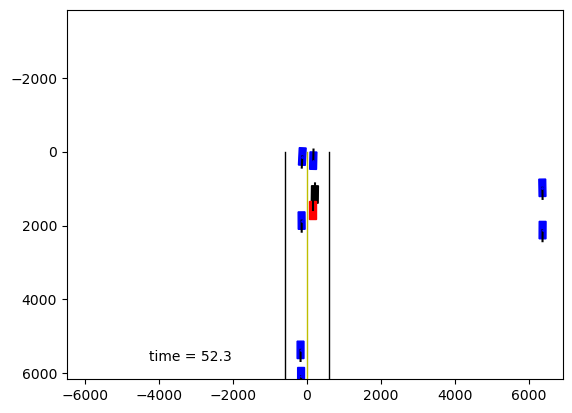

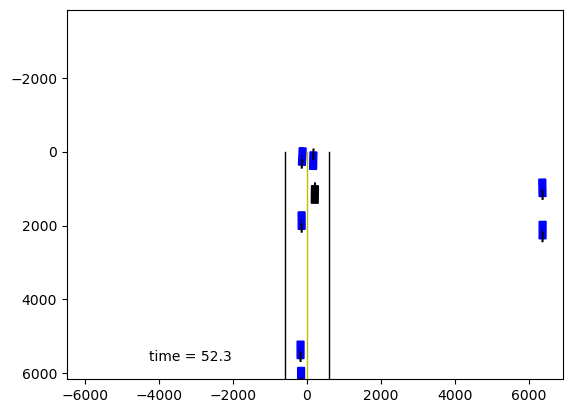

In [ ]:
ovm_update_fcn_best = lambda state, dt, params: update_1d_line_frame(state, dt, best_ovm_params, params, ovm_standard_derivatives)
ovm_update_fcn_hand_tuned = lambda state, dt, params: update_1d_line_frame(state, dt, ovm_params_hand_tuned, params, ovm_standard_derivatives)

run_index = 5
cur_demonstration = validation_demonstration_states_line_frame[run_index]

rollout_best = rollout_controller_line_frame(cur_demonstration, ovm_update_fcn_best, params)
rollout_hand_tuned = rollout_controller_line_frame(cur_demonstration, ovm_update_fcn_hand_tuned, params)

animate_trajectory(cur_demonstration,
                   rollout_best,
                   None, [0],
                   params.k_closest_vehicles, params.k_closest_pedestrians, 
                   percent_to_animate=1.0, render_speedup=8.0, subsample=7,
                   export_as_gif=True, export_as_mp4=False, filename=f"./Output/animation_ovm_best_validation_run_{run_index}")

animate_trajectory(cur_demonstration,
                   rollout_hand_tuned,
                   None, [0],
                   params.k_closest_vehicles, params.k_closest_pedestrians, 
                   percent_to_animate=1.0, render_speedup=8.0, subsample=7,
                   export_as_gif=True, export_as_mp4=False, filename=f"./Output/animation_ovm_hand_tuned_validation_run_{run_index}")



Now, we'll setup a training loop

In [ ]:
# Can treat this as a supervised learning problem 
# where our model maps from a sub-trajectory to a prediction on the sub-trajectory?

# def model_learning(sub_trajectories, deriv_function, initial_model_params, save_checkpoints=False, checkpoint_period=1, checkpoint_path=""):
#     """ 
#         Take in your dataset of sub-trajectories, then use the 
#         deriv_function to rollout the model on a batch, then update based on that.
#     """

#     # Setup the dataset

## Getting out a dataset of features based on what we've implemented here

#### We'll start by defining how to get features from the IDM and OVM models at each state 

In [ ]:
def get_IDM_features_from_state(state, model_params, params):
    """ 
        Get a vector of features associated with the IDM computation process from a particular state. 
    """
    # Flip the state so that the ego vehicle is facing up
    y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards = get_1d_state(state, params)

    # Actually run the model now that we've put it into 
    # a standard frame
    _, _, features = idm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params)

    return features

def get_OVM_features_from_state(state, model_params, params):
    """ 
        Get a vector of features associated with the IDM computation process from a particular state. 
    """
    # Flip the state so that the ego vehicle is facing up
    y, v_y, closest_vehicle_y, closest_vehicle_v_y, upwards = get_1d_state(state, params)

    # Actually run the model now that we've put it into 
    # a standard frame
    _, _, features = ovm_standard_derivatives(y, v_y, closest_vehicle_y, closest_vehicle_v_y, model_params, params)

    return features

# Ultimately we want an HDF5 file with keys X_train and X_validation,
# as well as an HDF5 file with keys Y_train and Y_validation. 
# okay so go through each demonstration, pull out the appropriate features. those features 
# have the information to align the brain data with them (can look back at how we paired training data for the 
# behavior cloning stuff to see how to do that). So then can collect the appropriate brain data.  
# essentially we'll call the get data from demonstrations (dealing with indexing and the IDs appropriately) 

In [ ]:
def demonstrations_to_feature_dict(demonstration_states, feature_fcn, model_params, parser_dict, all_ids, params):
    feature_dict = {}
    for state_matrix in demonstration_states:
        # Find the id index of the current demonstration 
        id_index = round(state_matrix[0, -1])
        id = all_ids[id_index]
        # assert the last row of state_matrix_line_frame is all equal
        assert(np.all(state_matrix[:, -1] == id_index))

        # if id isn't in the dictionary, add a matrix of zeros
        if id not in feature_dict:
            n_frames = parser_dict[id].playerPosition.shape[0]
            n_features = len(feature_fcn(state_matrix[0, :], model_params, params))
            feature_dict[id] = np.zeros((n_frames, n_features))

        # Get the features for each state in the matrix
        for i in range(state_matrix.shape[0]):
            state = state_matrix[i, :]
            index_in_run = np.round(state[-2].astype(int))
            feature_dict[id][index_in_run, :] = feature_fcn(state, model_params, params)

            # Print if any of the features are nan 
            if np.any(np.isnan(feature_dict[id][index_in_run, :])):
                print("nan feature: ", feature_dict[id][index_in_run, :])
                print("state: ", state)
                print("index in run: ", index_in_run)
                print("id: ", id)
                print("1d state: ", get_1d_state(state, params))

    return feature_dict

feature_dict_training = demonstrations_to_feature_dict(train_demonstration_states_line_frame, get_IDM_features_from_state, best_idm_params, parser_dict, all_ids, params)
feature_dict_validation = demonstrations_to_feature_dict(validation_demonstration_states_line_frame, get_IDM_features_from_state, best_idm_params, parser_dict, all_ids, params)

/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_20925/142609669.py:21: UserWarning: s < 0, crashed
  warnings.warn("s < 0, crashed")


In [ ]:
# get a list of parsers, brain data, and feature matrices based on the ids 
train_feature_matrices = []
train_brain_data_matrices = []
train_parsers = []

for id in feature_dict_training.keys():
    train_feature_matrices.append(feature_dict_training[id])
    train_brain_data_matrices.append(brain_data_dict[id])
    train_parsers.append(parser_dict[id])

validation_feature_matrices = []
validation_brain_data_matrices = []
validation_parsers = []

for id in feature_dict_validation.keys():
    validation_feature_matrices.append(feature_dict_validation[id])
    validation_brain_data_matrices.append(brain_data_dict[id])
    validation_parsers.append(parser_dict[id])

get averaged feature matrices 


In [ ]:
train_averaged_feature_matrices = [average_over_TRs(parser, feature_matrix) for parser, feature_matrix in zip(train_parsers, train_feature_matrices)]
validation_averaged_feature_matrices = [average_over_TRs(parser, feature_matrix) for parser, feature_matrix in zip(validation_parsers, validation_feature_matrices)]

delay each of the feature matrices 

In [ ]:
train_delayed_feature_matrices = []
delays = [1, 2, 3, 4]
delayer = Delayer(delays)
for averaged_matrix in train_averaged_feature_matrices:
    delayer.fit(averaged_matrix)
    delayed_matrix = delayer.transform(averaged_matrix)
    train_delayed_feature_matrices.append(delayed_matrix)

validation_delayed_feature_matrices = []
for averaged_matrix in validation_averaged_feature_matrices:
    delayer.fit(averaged_matrix)
    delayed_matrix = delayer.transform(averaged_matrix)
    validation_delayed_feature_matrices.append(delayed_matrix)


dropout the first 35 and last 5 TRs from all of the data


In [ ]:
train_delayed_feature_matrices = [matrix[35:-5, :] for matrix in train_delayed_feature_matrices]
validation_delayed_feature_matrices = [matrix[35:-5, :] for matrix in validation_delayed_feature_matrices]

train_brain_data_matrices = [matrix[35:-5, :] for matrix in train_brain_data_matrices]
validation_brain_data_matrices = [matrix[35:-5, :] for matrix in validation_brain_data_matrices]

Concatenate the matrices into big training matrices

In [ ]:
X_train = np.vstack(train_delayed_feature_matrices)
X_validation = np.vstack(validation_delayed_feature_matrices)

Y_train = np.vstack(train_brain_data_matrices)
Y_validation = np.vstack(validation_brain_data_matrices)

Save the matrices to an hdf5 file

In [ ]:
all_ids

array(['20210126SP_13-52-24', '20210126SP_14-38-49',
       '20210126SP_14-08-22', '20210126SP_14-23-30'], dtype='<U19')

In [ ]:
# save the matrices to an hdf5 file
feature_name = "idm"
feature_dataset = {'X_train': X_train, 'X_validation': X_validation}
save_hdf5_dataset(f"./Data/RegressionDatasets/{feature_name}_features.h5", feature_dataset)

brain_dataset = {'Y_train': Y_train, 'Y_validation': Y_validation}
save_hdf5_dataset(f"./Data/RegressionDatasets/aligned_brain_data.h5", brain_dataset)

# also save the run offsets
run_lengths = [matrix.shape[0] for matrix in train_delayed_feature_matrices]
run_offsets = [0] + np.cumsum(run_lengths).tolist()[:-1]
offsets_dataset = {'run_offsets': run_offsets}
save_hdf5_dataset("./Data/RegressionDatasets/train_run_offsets.h5", offsets_dataset)


Saving... Saved ./Data/RegressionDatasets/idm_features.h5
Saving... Saved ./Data/RegressionDatasets/aligned_brain_data.h5
Saving... Saved ./Data/RegressionDatasets/train_run_offsets.h5


#### Now, we'll define functions to get features from all of the demonstrations

In [ ]:
def get_features_from_demonstration(demonstration_states, features_from_state_fcn, params):
    return np.stack([features_from_state_fcn(demonstration_states[i, :], params) for i in range(demonstration_states.shape[0])])

def get_features_from_demonstrations(demonstrations, features_from_state_fcn, params):
    return np.vstack([get_features_from_demonstration(demonstration, features_from_state_fcn, params) for demonstration in demonstrations])

#### Average out the features and pull out the appropriate brain data for each demonstration

In [ ]:
def align_features_brain(state_matrix_line_frame, features, parser_dict, brain_dict, all_ids, params):
    # Pull out the appropriate part of the brain data for this demonstration
    id_index = round(state_matrix_line_frame[0, -1])
    # assert the last row of state_matrix_line_frame is all equal
    assert(np.all(state_matrix_line_frame[:, -1] == id_index))

    # Get the brain data matrix
    parser = parser_dict[all_ids[id_index]]
    brain_data = brain_dict[all_ids[id_index]]

    # Now, find the first and last TR we'd like to align with this
    raw_indices = np.rint(state_matrix_line_frame[:, -2]).astype(np.int32)
    first_index = raw_indices[0]
    last_index = raw_indices[-1]
    first_TR = raw_index_to_tr(parser, first_index)
    last_TR = raw_index_to_tr(parser, last_index)

    # Edge case where run has gone bast number of TRs
    last_TR = np.minimum(last_TR, brain_data.shape[0] - 1)

    averaged_features = np.zeros((last_TR - first_TR + 1, features.shape[1]))
    aligned_brain_data = np.zeros((last_TR - first_TR + 1, brain_data.shape[1]))

    # For now, we'll still include incomplete TRs.
    for i, TR in enumerate(range(first_TR, last_TR+1)):
        # Get the brain data for this TR
        aligned_brain_data[i, :] = brain_data[TR, :]

        chunk_start_index = tr_to_raw_index(parser, TR)
        chunk_end_index = tr_to_raw_index(parser, TR + 1)

        start_index_relative_to_demo = np.maximum(chunk_start_index - first_index, 0)
        end_index_relative_to_demo = np.minimum(chunk_end_index - first_index, state_matrix_line_frame.shape[0] - 1)
        # print("TR: ", TR)
        # print("first index: ", first_index)
        # print("last index: ", last_index)
        # print("chunk start: ", chunk_start_index)
        # print("chunk end: ", chunk_end_index)
        # print("end before min: ", chunk_end_index - first_index)
        # print("shape: ", state_matrix_line_frame.shape[0] - 1)
        # print("rel to demo: ", start_index_relative_to_demo, end_index_relative_to_demo)
        # print("averaging from {} to {}".format(start_index_relative_to_demo, end_index_relative_to_demo))
        averaged_features[i, :] = np.mean(features[start_index_relative_to_demo:end_index_relative_to_demo, :], axis=0)

    return averaged_features, aligned_brain_data    


In [ ]:
def get_averaged_aligned_features_from_demonstration(demonstration_states, features_from_state_fcn, parser_dict, brain_dict, all_ids, params):
    features = get_features_from_demonstration(demonstration_states, features_from_state_fcn, params)
    averaged_features, aligned_brain_data = align_features_brain(demonstration_states, features, parser_dict, brain_dict, all_ids, params)
    return averaged_features, aligned_brain_data

#### Load the appropriate parsers and brain data. 

In [ ]:
if False:
    # Load the parsers
    parser_filenames = [f"./Data/LogAndLabelData/{id}_positions.xml" for id in all_ids]
    parsers = load_log_data(parser_filenames)

    # Put the parsers in a dictionary mapping from run_id to parser
    parser_dict = {}
    for i in range(len(all_ids)):
        print("loading parser: ", all_ids[i])
        parser_dict[all_ids[i]] = parsers[i]

    # Load the brain data
    brain_filenames = [f"./Data/BrainData/{id}_combined data.npy" for id in all_ids]
    brain_data = load_brain_data(brain_filenames)

    # Put the brain data in a dictionary mapping from brain_id to brain data
    brain_data_dict = {}
    for i in range(len(all_ids)):
        brain_data_dict[all_ids[i]] = brain_data[i]

loading parser:  20210126SP_13-52-24
loading parser:  20210126SP_14-38-49
loading parser:  20210126SP_14-08-22
loading parser:  20210126SP_14-23-30


In [ ]:
#np.any(np.isnan(feat_brain_list_validation_idm[3][0]))

In [ ]:
#np.any(np.isnan(X_validation_idm))

In [ ]:
parsers[2].firstTRFrame + 96 * 2.0045 * 15

NameError: name 'parsers' is not defined

In [ ]:
tr_to_raw_index(parsers[2], 96)


3256

In [ ]:
raw_index_to_tr(parsers[2], 3255)

95

In [ ]:
raw_index_to_tr(parsers[2], tr_to_raw_index(parsers[2], 96))

96

In [ ]:
# Test out getting the aligned features
averaged_features, aligned_brain_data = get_averaged_aligned_features_from_demonstration(validation_demonstration_states_line_frame[3], get_IDM_features_from_state, parser_dict, brain_data_dict, all_ids, params)

# check if averaged features are nan
print(np.any(np.isnan(averaged_features)))


False


In [ ]:
# Now, build the training set
feat_brain_list_train_idm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_IDM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in train_demonstration_states_line_frame]
X_train_idm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_train_idm])
Y_train = np.vstack([feat_brain[1] for feat_brain in feat_brain_list_train_idm])

demonstration_lengths = [feat_brain[0].shape[0] for feat_brain in feat_brain_list_train_idm]
demonstration_offsets = np.cumsum(demonstration_lengths)
demonstration_offsets = np.insert(demonstration_offsets, 0, 0)
demonstration_offsets = demonstration_offsets[:-1]

# the brain data should match between, so just pull out X features for ovm
feat_brain_list_train_ovm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_OVM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in train_demonstration_states_line_frame]
X_train_ovm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_train_ovm])

# Now, build the validation set
feat_brain_list_validation_idm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_IDM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in validation_demonstration_states_line_frame]
X_validation_idm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_validation_idm])
Y_validation = np.vstack([feat_brain[1] for feat_brain in feat_brain_list_validation_idm])

# the brain data should match between, so just pull out X features for ovm
feat_brain_list_validation_ovm = [ get_averaged_aligned_features_from_demonstration(demonstration, get_OVM_features_from_state, parser_dict, brain_data_dict, all_ids, params) for demonstration in validation_demonstration_states_line_frame]
X_validation_ovm = np.vstack([feat_brain[0] for feat_brain in feat_brain_list_validation_ovm])

# Save to an HDF5 file
feature_name = "idm"
feature_dataset = {'X_train': X_train_idm, 'X_validation': X_validation_idm}
save_hdf5_dataset(f"./Data/RegressionDatasets/{feature_name}_features.h5", feature_dataset)

feature_name = "ovm"
feature_dataset = {'X_train': X_train_ovm, 'X_validation': X_validation_ovm}
save_hdf5_dataset(f"./Data/RegressionDatasets/{feature_name}_features.h5", feature_dataset)

brain_dataset = {'Y_train': Y_train, 'Y_validation': Y_validation}
save_hdf5_dataset(f"./Data/RegressionDatasets/aligned_brain_data.h5", brain_dataset)


# save the demonstration offsets
offsets_dataset = {'demonstration_offsets': demonstration_offsets}
save_hdf5_dataset("./Data/RegressionDatasets/demonstration_offsets.h5", offsets_dataset)

/var/folders/ks/z7_nk3k1019gj5y1xh7flgb40000gp/T/ipykernel_18342/703097918.py:24: UserWarning: s < 0, crashed
  warnings.warn("s < 0, crashed")


Saving... Saved ./Data/RegressionDatasets/idm_features.h5
Saving... Saved ./Data/RegressionDatasets/ovm_features.h5
Saving... Saved ./Data/RegressionDatasets/aligned_brain_data.h5
Saving... Saved ./Data/RegressionDatasets/demonstration_offsets.h5


In [ ]:
# test loading the dataset
test = load_hdf5_array(f"./Data/RegressionDatasets/{feature_name}_features.h5", 'X_train')

In [ ]:
# check if any nan in X_train 
np.any(np.isnan(X_validation_idm))

False

In [ ]:
# Find nan index in X_validation_idm
nan_index = np.argwhere(np.isnan(X_validation_idm))
nan_index

array([], shape=(0, 2), dtype=int64)